The NREL S805 airfoil and the rest of the family have been specifically designed for use in wind turbines. The S805 has been studied at the Delft low-turbulence wind tunnel[1], including transition points and oil-flow photographs.
The S805A airfoil is a modification of this airfoil to improve the drag, based on the experimental results of the S805.
While the improvements are visible in the numerical results here, I am not aware of any windtunnel results.

## Viiflow Parameters
The Delft low-turbulence wind tunnel is commonly used with a critical amplification factor of 11.2[2], but the transition locations are better matched by assuming a bit more turbulent conditions at 10.2. All calculations are performed with a Mach Number assuming a cord length of 0.5[1] and the geometry is taken from the reference.

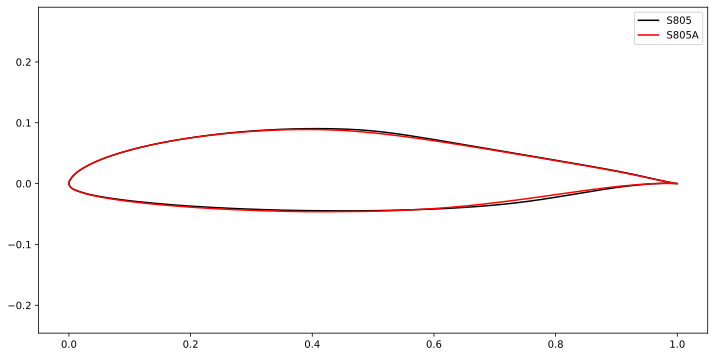

In [1]:
import viiflow as vf
import viiflowtools.vf_tools as vft
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import logging
logging.getLogger().setLevel(logging.WARNING)
matplotlib.rcParams['figure.figsize'] = [12, 6]

# Read Airfoil Data
N = 220
S805 = vft.repanel(vft.read_selig("S805.dat"),N)
S805A = vft.repanel(vft.read_selig("S805A.dat"),N)

fig,ax = plt.subplots(1,1)
ax.plot(S805[0,:],S805[1,:],'-k',label="S805")
ax.plot(S805A[0,:],S805A[1,:],'-r',label="S805A")
ax.axis('equal')
ax.legend()

## Calculation

In [2]:
results = {} # Dictionary of results
AOARange = np.arange(-5,18.5,.25)
# Go over RE range
af=-1
for airfoil in [S805,S805A]:
    af+=1
    results[af] = {} # Dictionary of results
    for RE in [5e5, 7e5, 10e5, 15e5, 20e5]:
        print("RE %g"%RE)
        # Settings
        ncrit = 10.2
        Mach = 0.04*RE/5e5 # c = 0.5m, assuming 20°C
        s = vf.setup(Re=RE,Ma=Mach,Ncrit=ncrit,Alpha=AOARange[0],IterateWakes=False)
        s.Silent = True
        # (Maximum) internal iterations
        s.Itermax = 100

        results[af][RE] = {} # Sub-Dictionary of results
        results[af][RE]["AOA"] = []
        results[af][RE]["CL"] = []
        results[af][RE]["CD"] = []
        results[af][RE]["TRUP"] = []
        results[af][RE]["TRLO"] = []

        # Go over AOA range
        faults = 0
        init = True
        for alpha in AOARange:

            # Set current alpha and set res/grad to None to tell viiflow that they are not valid
            s.Alpha = alpha
            res = None
            grad = None

            # Set-up and initialize based on inviscid panel solution
            # This calculates panel operator
            if init:
                [p,bl,x] = vf.init([airfoil],s)
                init = False

            # Run viiflow
            [x,flag,res,grad,_] = vf.iter(x,bl,p,s,res,grad)
            # If converged add to cl/cd vectors (could check flag as well, but this allows custom tolerance 
            # to use the results anyways)
            if flag:
                results[af][RE]["AOA"].append(alpha)
                results[af][RE]["CL"].append(p.CL)
                results[af][RE]["CD"].append(bl[0].CD)
                # Calculate transition position based on BL variable
                results[af][RE]["TRUP"].append( \
                    np.interp(bl[0].ST-bl[0].bl_fl.node_tr_up.xi[0],p.foils[0].S,p.foils[0].X[0,:]))
                results[af][RE]["TRLO"].append( \
                    np.interp(bl[0].ST+bl[0].bl_fl.node_tr_lo.xi[0],p.foils[0].S,p.foils[0].X[0,:]))
                faults = 0
            else:
                faults+=1
                init = True

            # Skip current polar if 4 unconverged results in a row
            if faults>3:
                print("Exiting RE %u polar calculation at AOA %f°"%(RE,alpha))
                break


RE 500000
RE 700000
RE 1e+06
RE 1.5e+06
RE 2e+06
RE 500000
RE 700000
RE 1e+06


 xi=1.049037,delta=0.000425,theta=0.000146,ue=0.867868,n/ct=0.017028
 xi=1.994936,delta=0.000336,theta=0.000216,ue=0.257269,n/ct=0.042698
 xi=1.994936,delta=0.000328,theta=0.000235,ue=0.252922,n/ct=0.037332


RE 1.5e+06


 xi=0.885782,delta=0.016928,theta=0.006478,ue=1.022377,n/ct=0.057475


RE 2e+06


## Aerodynamic Polars
Both the experimental values and the viiflow calculations show that the design goal of a “laminar bucket” up to a lift coefficient of 0.9 is quite well achieved.

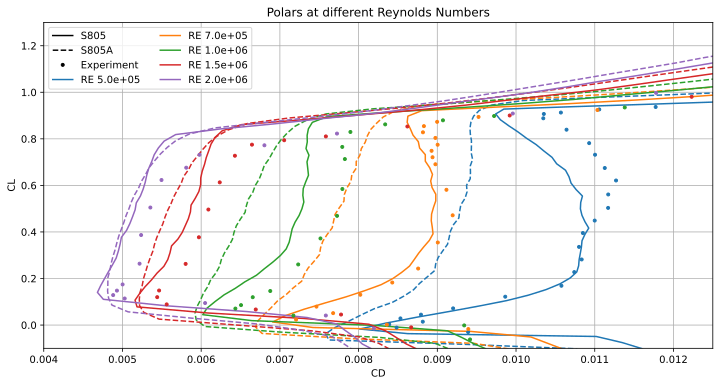

In [3]:
EXPRES=np.genfromtxt("S805Polars.csv",delimiter=",",names=True)
matplotlib.rcParams['figure.figsize'] = [12, 6]
expnames = ['EXPPOLAR5','EXPPOLAR7','EXPPOLAR10','EXPPOLAR15','EXPPOLAR20']
resnames = [5e5,7e5,10e5,15e5,20e5]
colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:pink"]

fix,ax = plt.subplots(1,1)
# Add pseudo lines for legend
ax.plot([],[],'-k',label="S805")
ax.plot([],[],'--k',label="S805A")
ax.plot([],[],'k',marker=".",linestyle = 'None',label="Experiment")
for k in range(len(resnames)):
    ax.plot(results[0][resnames[k]]["CD"],results[0][resnames[k]]["CL"], color=colors[k],label="RE %2.1e"%resnames[k])
    ax.plot(results[1][resnames[k]]["CD"],results[1][resnames[k]]["CL"], '--',color=colors[k])
    
for k in range(len(expnames)):
    ax.plot(EXPRES['%s_X'%expnames[k]],EXPRES['%s_Y'%expnames[k]],marker=".",linestyle = 'None', color=colors[k])

ax.set_xlabel('CD')
ax.set_ylabel('CL')
ax.set_xlim([0.004,0.0125])
ax.set_ylim([-.1,1.3])
ax.grid(True)
ax.set_title("Polars at different Reynolds Numbers");
ax.legend(ncol=2)

## Transition Location
The transition location behavior in shape and with respect to increasing Reynolds Number is generally well described by the computational results. At higher angles of attack, the calculations in general assume earlier transitions near the leading edge at high angles of attack. This, I assume, leads to lower maximum lift than calculated.

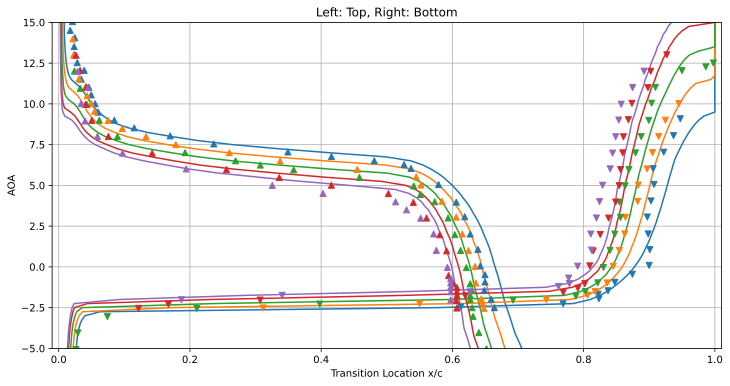

In [4]:
EXPRES=np.genfromtxt("S805TransitionLocations.csv",delimiter=",",names=True)
expnames1 = ['EXPBOTRE500','EXPBOTRE700','EXPBOTRE1000','EXPBOTRE1500','EXPBOTRE2000']
expnames2 = ['EXPTOPRE500','EXPTOPRE700','EXPTOPRE1000','EXPTOPRE1500','EXPTOPRE2000']
fix,ax = plt.subplots(1,1)
for k in range(len(resnames)):
    plt.plot(results[0][resnames[k]]["TRUP"],results[0][resnames[k]]["AOA"], color=colors[k])
    plt.plot(results[0][resnames[k]]["TRLO"],results[0][resnames[k]]["AOA"], color=colors[k])
for k in range(len(expnames)):
    plt.plot(EXPRES['%s_X'%expnames1[k]],EXPRES['%s_Y'%expnames1[k]],marker="v",linestyle = 'None', color=colors[k])
    plt.plot(EXPRES['%s_X'%expnames2[k]],EXPRES['%s_Y'%expnames2[k]],marker="^",linestyle = 'None', color=colors[k])

plt.xlabel('Transition Location x/c')
plt.ylabel('AOA')
plt.title('Left: Top, Right: Bottom')
plt.ylim([-5,15])
plt.xlim([-.01,1.01])
plt.grid(True)
plt.show()

## Lift Coefficients
The lift slope and zero lift angle of attack at low angles of attack, from -3° to 7°, is very good. Above 7°, the prediction and experiment diverge and lead to a disagreement in maximum lift coefficient and stall behavior. Although the maximum angle of attack is quite accurate.

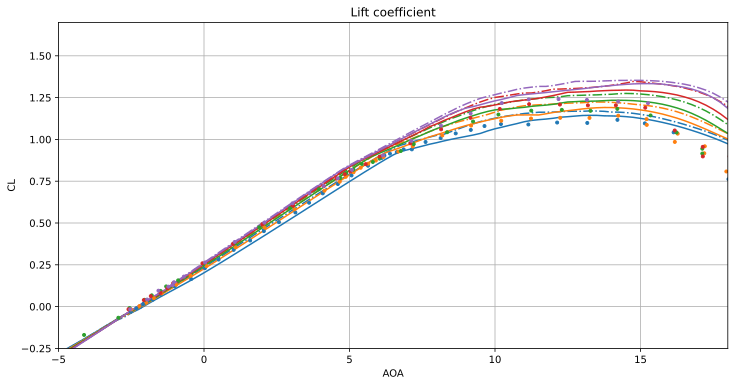

In [5]:
marker = None
fix,ax = plt.subplots(1,1)
EXPRES=np.genfromtxt("S805CL.csv",delimiter=",",names=True)
for k in range(len(resnames)):
    plt.plot(results[0][resnames[k]]["AOA"],results[0][resnames[k]]["CL"],color=colors[k])
    plt.plot(results[1][resnames[k]]["AOA"],results[1][resnames[k]]["CL"], '-.',color=colors[k])

plt.plot(EXPRES['EXPRE500_X'],EXPRES['EXPRE500_Y'],marker=".",linestyle = 'None', color="tab:blue")
plt.plot(EXPRES['EXPRE700_X'],EXPRES['EXPRE700_Y'],marker=".", linestyle = 'None',color='tab:orange')
plt.plot(EXPRES['EXPRE1000_X'],EXPRES['EXPRE1000_Y'],marker=".", linestyle = 'None',color='tab:green')
plt.plot(EXPRES['EXPRE1500_X'],EXPRES['EXPRE1500_Y'],marker=".", linestyle = 'None',color='tab:red')
plt.plot(EXPRES['EXPRE2000_X'],EXPRES['EXPRE2000_Y'],marker=".", linestyle = 'None',color='tab:purple')

plt.xlabel('AOA')
plt.ylabel('CL')

plt.xlim([-5,18])
plt.ylim([-.25,1.7])
plt.grid(True)
plt.title("Lift coefficient")
plt.show()

## References

[1] D.Somers, *Design and Experimental Results for the S805 airfoil.* NREL/SR-440-6917

[2] Van Ingen, J. L. *The eN method for transition prediction: historical review of work at TU Delft.* AIAA, 2008.